In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from dotenv import load_dotenv
import os
import re
from sklearn.preprocessing import MultiLabelBinarizer

In [39]:
load_dotenv()
USERNAME = os.getenv('USERNAME')
PASSWORD = os.getenv('PASSWORD')
connection = psycopg2.connect(host='localhost', database='jobhunter', user=USERNAME, password=PASSWORD)
cursor = connection.cursor()

jobs = pd.read_sql('SELECT * FROM jobs', connection)
companies = pd.read_sql('SELECT * FROM companies', connection)
hard_skills = pd.read_sql('SELECT * FROM hard_skills', connection)
soft_skills = pd.read_sql('SELECT * FROM soft_skills', connection)

/tmp/ipykernel_4915/1940425611.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  jobs = pd.read_sql('SELECT * FROM jobs', connection)
/tmp/ipykernel_4915/1940425611.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companies = pd.read_sql('SELECT * FROM companies', connection)
/tmp/ipykernel_4915/1940425611.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hard_skills = pd.read_sql('SELECT * FROM hard_skills', connection)
/tmp/ipykernel_4915/1940425611.py:10: UserWarning: pandas only supports SQLAlchemy connectable (e

In [40]:
jobs

,name,salary,link,type,hard_skills,communication,customer_service,leadership,project_management,management,analytics,teamwork,problem_solving,research,adaptability,independence,time_management,requested_job,company,location
0,Information Technology Security Analyst,"$60,000.00/yr - $90,000.00/yr",https://www.linkedin.com/jobs/view/information...,Entry level,"[information security, security assessments, i...",8,4,5,6,5,7,8,9,7,6,5,6,Cybersecurity,"Ingles Markets, Inc.","Black Mountain, NC"
1,IT Security Engineer,"$100,000.00/yr - $130,000.00/yr",https://www.linkedin.com/jobs/view/it-security...,Entry level,"[incident response, risk management, vulnerabi...",8,4,5,6,6,7,8,9,7,6,5,6,Security Engineer,Robert Half,"West Valley City, UT"
2,"Software Engineer, New Grad",NaN,https://www.linkedin.com/jobs/view/software-en...,Entry level,"[programming, scripting, scripting, programming]",8,4,7,9,6,5,9,8,7,8,7,6,Security Engineer,Stripe,"San Francisco, CA"
3,"Cybersecurity, Privacy and Forensics - Cyber I...","$84,000.00/yr - $202,000.00/yr",https://www.linkedin.com/jobs/view/cybersecuri...,Entry level,"[incident response, data protection, forensics...",8,5,7,6,7,9,8,10,8,9,6,7,Cybersecurity Consultant,PwC,"Minneapolis, MN"
4,Information Security Engineer I,"$66,297.00/yr - $86,100.00/yr",https://www.linkedin.com/jobs/view/information...,Entry level,"[information security, analytical skills, secu...",8,4,5,9,6,8,7,9,6,7,5,7,Security Engineer,Conduent,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,Junior Cyber Security Specialist (0011),"$70,000.00/yr - $95,000.00/yr",https://www.linkedin.com/jobs/view/junior-cybe...,Associate,"[security tools, risk management]",8,7,5,9,6,7,8,9,6,7,6,8,Cybersecurity Consultant,OCT Consulting LLC,"Silver Spring, MD"
230,"Cyber Security Specialist - Associate, Securit...",NaN,https://www.linkedin.com/jobs/view/cyber-secur...,Entry level,"[incident response, malware analysis, document...",8,4,6,5,5,7,8,9,6,7,6,6,Cybersecurity Consultant,Baptist Health,"Florida, United States"
231,Cybersecurity Incident Response Intern,$24.00/hr - $36.00/hr,https://www.linkedin.com/jobs/view/cybersecuri...,Internship,"[incident response, scripting, networking, win...",8,4,5,6,5,7,9,10,7,9,6,8,Cybersecurity Consultant,Cboe Global Markets,"New York, NY"
232,Cybersecurity Incident Response Intern,$24.00/hr - $36.00/hr,https://www.linkedin.com/jobs/view/cybersecuri...,Internship,"[incident response, scripting, incident respon...",7,4,3,5,3,6,9,10,6,8,7,6,Cybersecurity Consultant,Cboe Global Markets,"Chicago, IL"


### Converting LinkedIn Salaries into Usable Data
The LinkedIn salaries exist in three forms: annual, hourly, and NaN. NaN will obviously be dropped. Annual and hourly can both be parsed with regex, though I'll have to convert hourly to an annual equivalent (I'll assume 40 hours a week for 52 weeks)

In [41]:
# Converting LinkedIn salaries into usable data
for index, job in jobs.iterrows():
    if "hr" in jobs.at[index, "salary"]:
        pay_range = re.search("\$(\d+\.\d{2})/hr - \$(\d+\.\d{2})/hr", jobs.at[index, "salary"])
        low_range, high_range = float(pay_range.group(1)), float(pay_range.group(2))
        jobs.at[index, "adjusted_salary"] = ((low_range + high_range) / 2.0) * 40 * 52 # Converting hourly to salary assuming a 40 hour work week for 52 weeks
    elif "yr" in jobs.at[index, "salary"]:
        pay_range = re.search("\$([\d|\,]+\.\d{2})/yr - \$([\d|\,]+\.\d{2})/yr", jobs.at[index, "salary"])
        low_range, high_range = float(pay_range.group(1).replace(',', '')), float(pay_range.group(2).replace(',', ''))
        jobs.at[index, "adjusted_salary"] = (low_range + high_range) / 2.0 # Using average salary based on listed top and bottom end
jobs = jobs[jobs['adjusted_salary'].notna()]
jobs = jobs.drop(columns=['salary', 'link'])

In [62]:
jobs['adjusted_salary']

0       75000.0
1      115000.0
3      143000.0
4       76198.5
6      390000.0
         ...   
131     90000.0
132    320000.0
134    105000.0
140     97365.0
141     90000.0
Name: adjusted_salary, Length: 78, dtype: float64

### Handling Categorical Variables
Name, Type, Hard Skills, Requested Job, Company, and Location represent the categorical columns. As far as name, requested job, company, and location go, they'll be used for identification and analysis later, so you'll see them dropped while I'm in the midst of processing but not as a permanent change to the dataframe. Type can be encoded into integer values so that it's still useful. Hard Skills is where things get a bit finnicky. What I'll do is use a MultiLabelBinarizer to create a column for every single hard skill. For each job, a 1 in a hard skill column indicates that skill's presence as a key part of the job.

In [42]:
mlb = MultiLabelBinarizer()
jobs = jobs.join(pd.DataFrame(mlb.fit_transform(jobs['hard_skills']), columns=mlb.classes_))
jobs = jobs.drop(columns=['hard_skills'])
jobs['type'].replace(['Internship', 'Entry level', 'Associate', 'Mid-Senior', 'Director', 'Executive'], [0, 1, 2, 3, 4, 5], inplace=True)
jobs

/tmp/ipykernel_4915/749155828.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  jobs['type'].replace(['Internship', 'Entry level', 'Associate', 'Mid-Senior', 'Director', 'Executive'], [0, 1, 2, 3, 4, 5], inplace=True)
/tmp/ipykernel_4915/749155828.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


,name,type,communication,customer_service,leadership,project_management,management,analytics,teamwork,problem_solving,...,security frameworks,security tools,security training,sql,technical analysis,threat detection,troubleshooting,vendor management,vulnerability assessment,windows operating system
0,Information Technology Security Analyst,1,8,4,5,6,5,7,8,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,IT Security Engineer,1,8,4,5,6,6,7,8,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,"Cybersecurity, Privacy and Forensics - Cyber I...",1,8,5,7,6,7,9,8,10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Information Security Engineer I,1,8,4,5,9,6,8,7,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Consultant - Cyber Security Analyst,2,8,5,7,6,7,8,6,9,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Senior IT Sales Executive � MSP and Cybersecurity,1,9,8,7,8,7,6,8,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,IT Cybersecurity Specialist (INFOSEC),2,8,7,4,5,5,6,6,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,Junior Cyber Security Specialist (0011),2,8,7,5,9,6,7,8,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231,Cybersecurity Incident Response Intern,0,8,4,5,6,5,7,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clearing out NaNs
During the process of prepping the database for analysis, particularly niche hard skills (think 1 out of several hundreds) or hard skills deemed to not be relevant to the field being investigated (in this case being cybersecurity) were pruned from the dataset. This resulted in some jobs not listing any hard skills. Additionally, some jobs were improperly analyzed by the AI due to network or token limitations. In order to adjust for this, we'll be removing any jobs that have NaN in hard skill columns (indicating a failure to parse any hard skills or said processing failure).

In [63]:
jobs = jobs[jobs['adjusted_salary'].notna()]
jobs = jobs[jobs['security frameworks'].notna()]
jobs

0       75000.0
1      115000.0
3      143000.0
4       76198.5
6      390000.0
         ...   
131     90000.0
132    320000.0
134    105000.0
140     97365.0
141     90000.0
Name: adjusted_salary, Length: 78, dtype: float64

### Cleaning the Data (Multicollinearity)
By the very nature of how this data was gathered, we're basically guaranteed to have some multicollinearity sprinkled throughout our columns. I did pre-clean the data before beginning this analysis, but that was done by combining near identical hard skills under a single umbrella skill. This will be done in a manner such to determine what other relationships lie within our data that might prove to cause us issues. Any areas of extremely high multicollinearity will have one of the 

<Axes: >

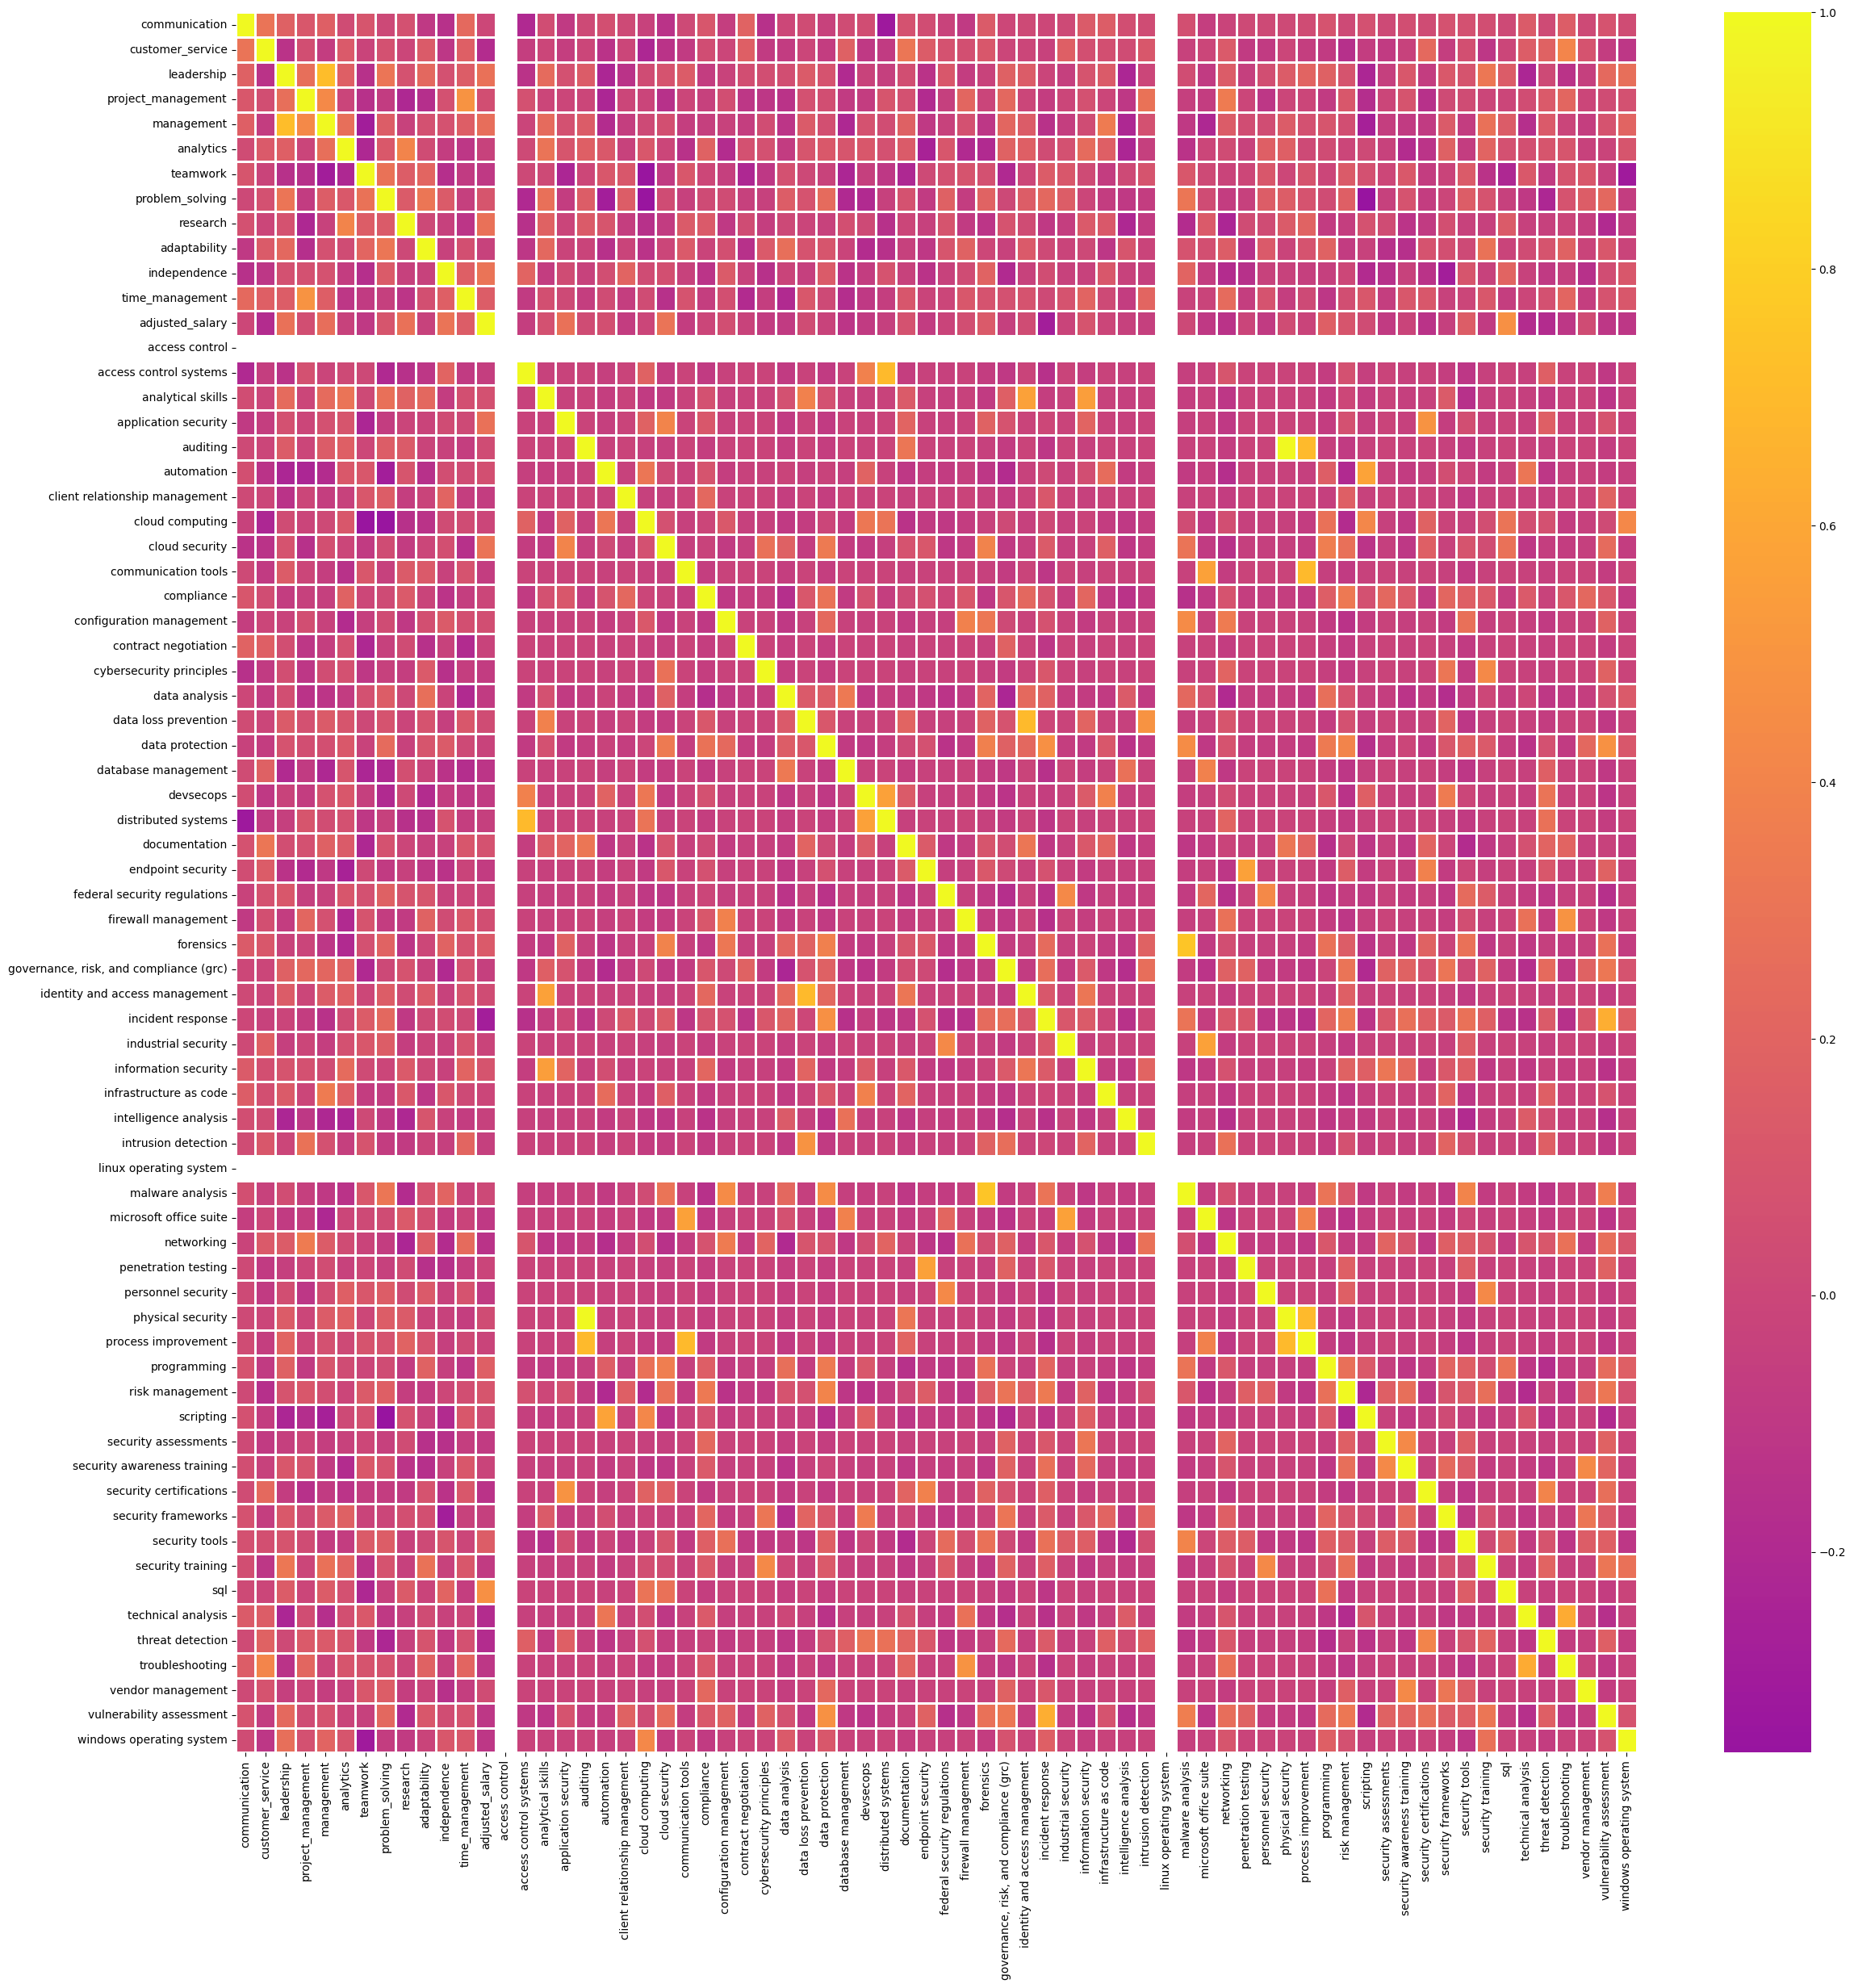

In [61]:
f, ax = plt.subplots(figsize = (28, 28))
sns.heatmap(jobs.drop(columns = ['name', 'type', 'requested_job', 'company', 'location']).corr(), center = 0, linewidths = 1, cmap = "plasma")

### Observations
There are a couple bright spots within the data. Now, some of these instances are to be expected, such as with incident response and vulnerability assessments, but others are too great to write off (see auditing x physical security). To resolve such examples, we'll make use of PCA to create a combined metric as to not lose potential data.

We can step away from the multicollinearity observation for a moment and take a look at purely correlation though. In particular, looking at adjusted_salary, we can see that there aren't any hard skills OR soft skills that alone massively influence it. This is to be expected as the presence or lack of a single skill doesn't equate proficiency at a role, thus I'd expect that we'll instead see correlation within groupings of skills later on in our analysis.

<Axes: >

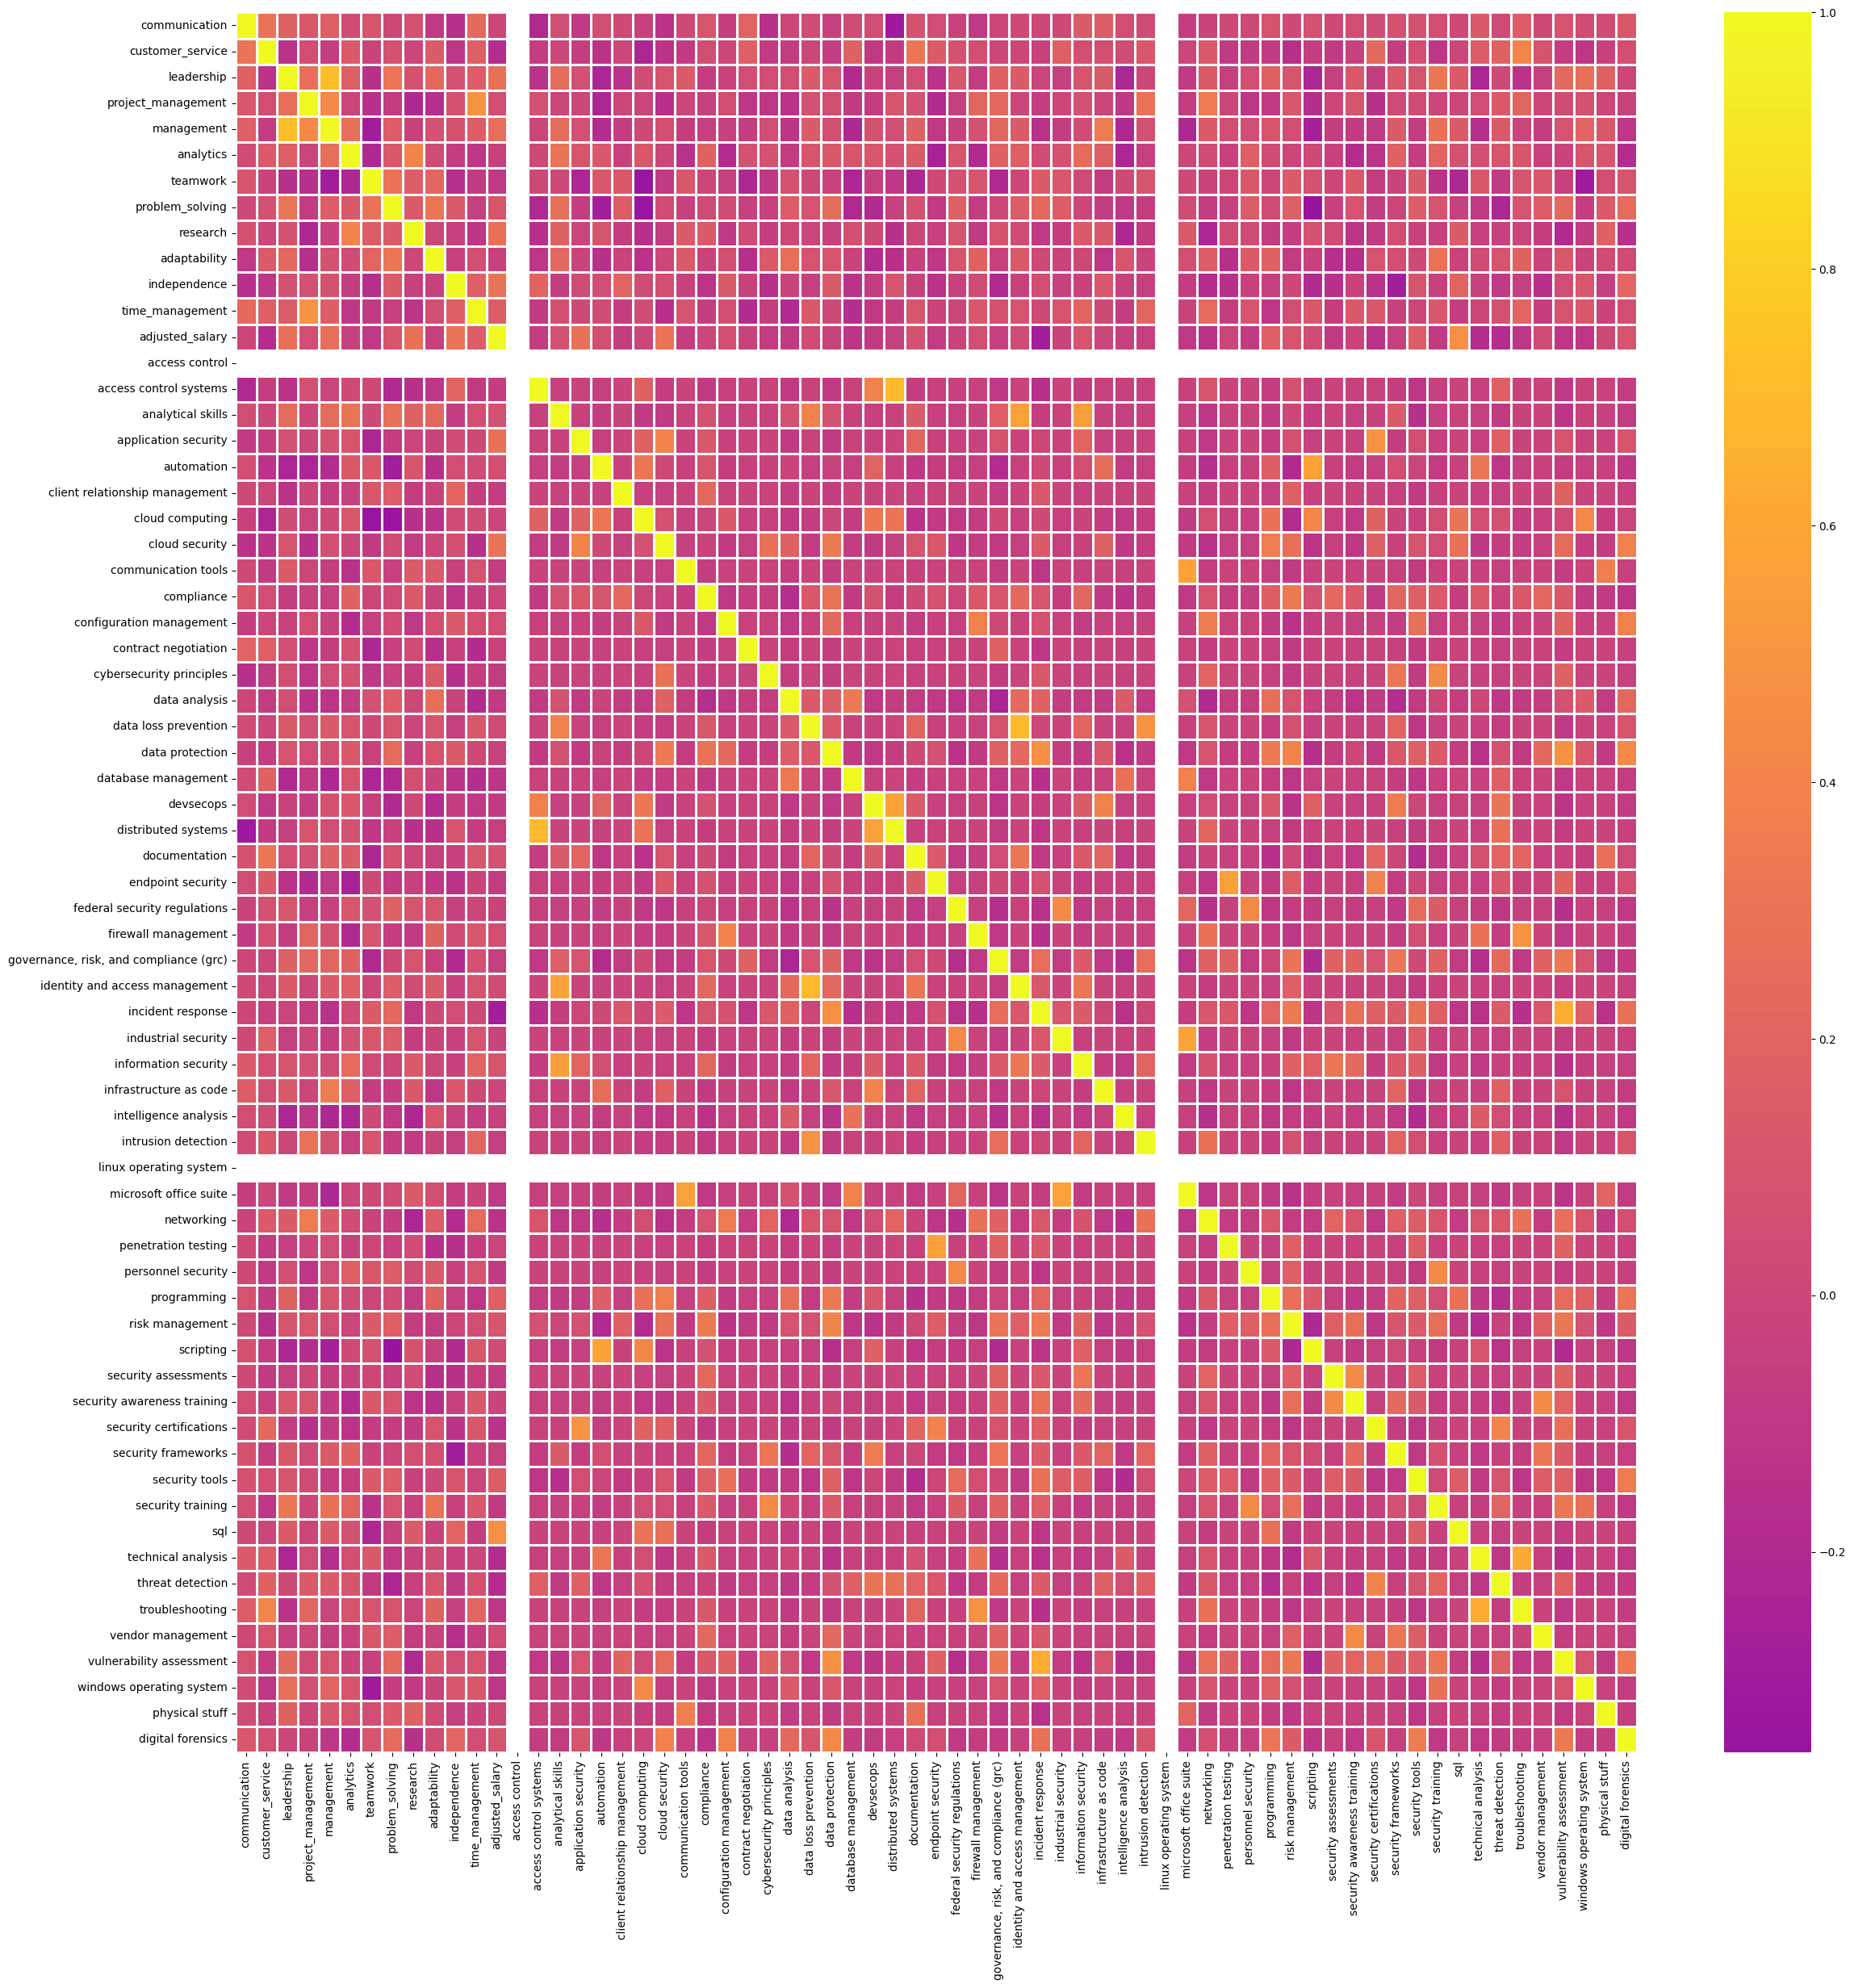

In [71]:
from sklearn.decomposition import PCA

pca_fixer = PCA(n_components = 1)

jobs_fixed = jobs.copy()
jobs_fixed['physical stuff'] = pca_fixer.fit_transform(jobs[['physical security', 'auditing', 'process improvement']])
jobs_fixed['digital forensics'] = pca_fixer.fit_transform(jobs[['forensics', 'malware analysis']])
jobs_fixed = jobs_fixed.drop(columns = ['physical security', 'auditing', 'forensics', 'malware analysis', 'process improvement'], axis = 1)
f, ax = plt.subplots(figsize = (28, 28))
sns.heatmap(jobs_fixed.drop(columns = ['name', 'type', 'requested_job', 'company', 'location']).corr(), center = 0, linewidths = 1, cmap = "plasma")
#jobs_fixed['physical security']

There are still bright spots sprinkled throughout our heatmap, but I'm willing to let the worst of these slide because their relationship is one I'd first like to see more within my analysis due to their nature in the field. If they prove to be too influential on my resulting data, I'll cleanse them with PCA as well.

### Analysis
Now that we've cleansed our data some, let's start making some basic observations. We'll start off by observing the aggregate rating of our soft skills and associated salary levels with each rating of said soft skills.

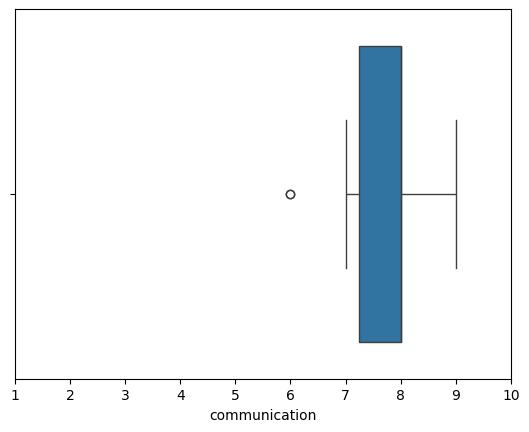

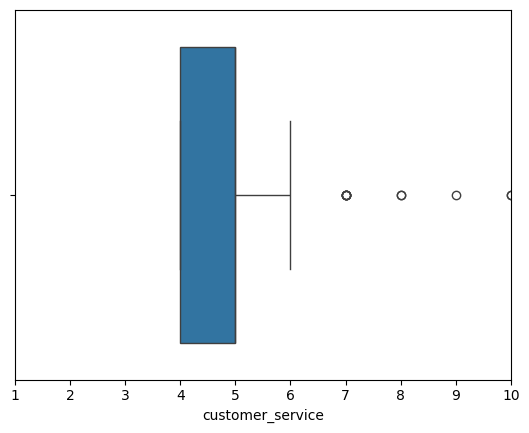

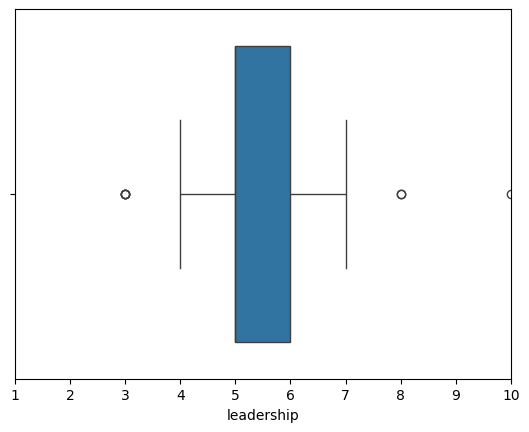

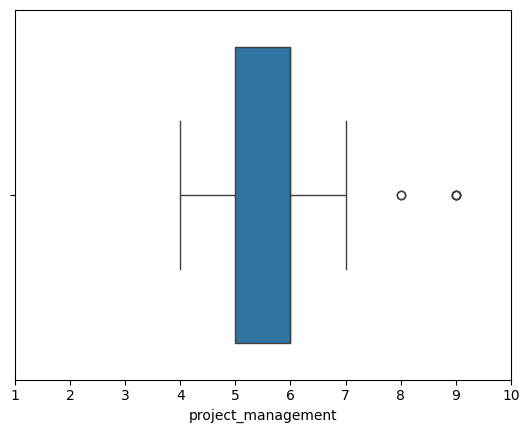

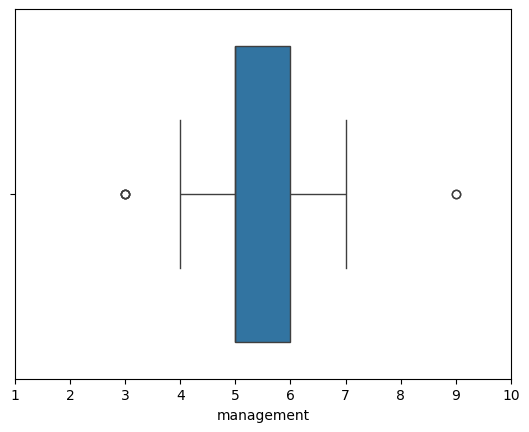

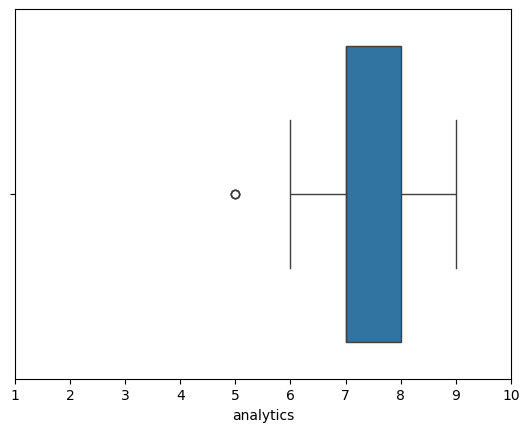

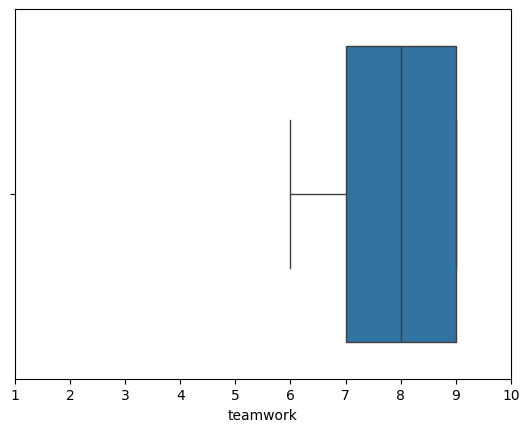

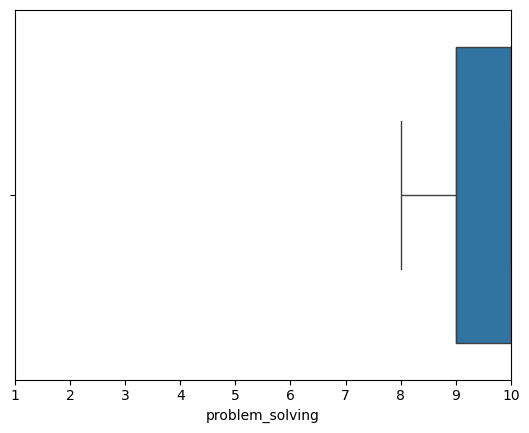

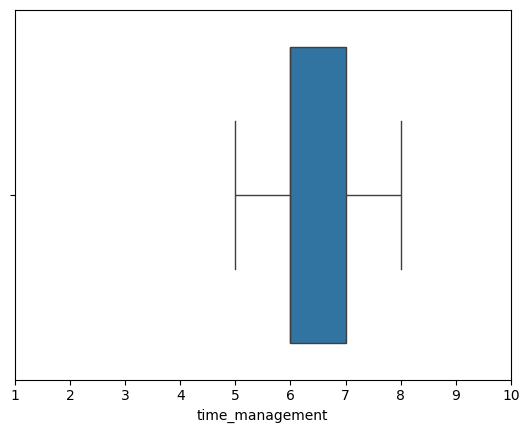

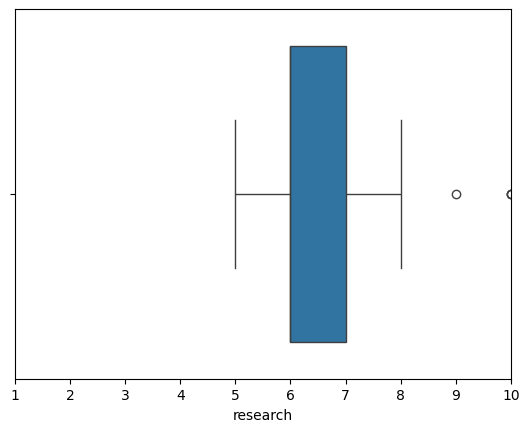

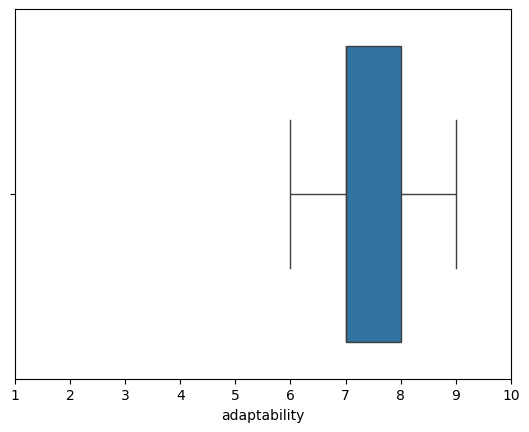

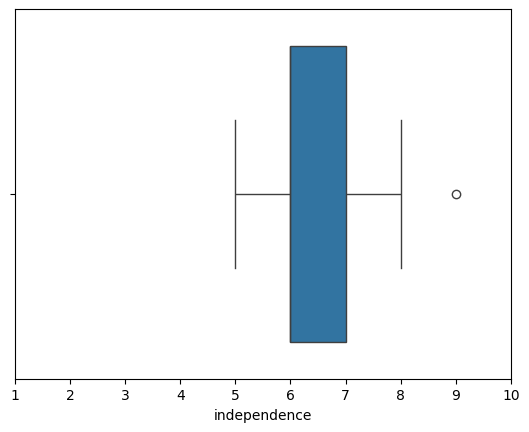

In [97]:
soft_skills = ['communication', 'customer_service', 'leadership', 'project_management', 'management', 'analytics', 'teamwork', 'problem_solving', 'time_management', 'research', 'adaptability', 'independence']
for i in soft_skills:
    bx = sns.boxplot(x = jobs_fixed[i])
    bx.set_xlim(1, 10)
    plt.show()

In [91]:
for i in soft_skills:
    print("{}: {} | {} <----> {} | {} - {} = {}".format(i, jobs_fixed[i].describe()['mean'], jobs_fixed[i].describe()['25%'], jobs_fixed[i].describe()['75%'], jobs_fixed[i].describe()['max'], jobs_fixed[i].describe()['min'], jobs_fixed[i].describe()['max'] - jobs_fixed[i].describe()['min']))

communication: 7.858974358974359 | 7.25 <----> 8.0 | 9.0 - 6.0 = 3.0
customer_service: 5.0 | 4.0 <----> 5.0 | 10.0 - 4.0 = 6.0
leadership: 5.4743589743589745 | 5.0 <----> 6.0 | 10.0 - 3.0 = 7.0
project_management: 6.0256410256410255 | 5.0 <----> 6.0 | 9.0 - 4.0 = 5.0
management: 5.551282051282051 | 5.0 <----> 6.0 | 9.0 - 3.0 = 6.0
analytics: 7.358974358974359 | 7.0 <----> 8.0 | 9.0 - 5.0 = 4.0
teamwork: 7.923076923076923 | 7.0 <----> 9.0 | 9.0 - 6.0 = 3.0
problem_solving: 9.217948717948717 | 9.0 <----> 10.0 | 10.0 - 8.0 = 2.0
time_management: 6.410256410256411 | 6.0 <----> 7.0 | 8.0 - 5.0 = 3.0
research: 6.576923076923077 | 6.0 <----> 7.0 | 10.0 - 5.0 = 5.0
adaptability: 7.089743589743589 | 7.0 <----> 8.0 | 9.0 - 6.0 = 3.0
independence: 6.3076923076923075 | 6.0 <----> 7.0 | 9.0 - 5.0 = 4.0


So what does this data tell us? Well, problem solving by far received the highest average rating of all of our soft skills. In fact we could imagine our soft skills falling into tiers:

**Top Tier (9.00 - 10.00)**: Problem Solving

*Gap between 8 and 9 because Problem Solving is just that much further ahead*

**High Tier (7.00 - 7.99)**: Teamwork, Communication, Analytics, Adaptability

**Mid Tier (6.00 - 6.99)**: Research, Time Management, Independence, Project Management

**Low Tier (5.00 - 5.99)**: Management, Leadership, Customer Service

What does this mean for our analysis? Well, based on these ratings, one might assume that problem solving would demonstrate an increased correlation with adjusted_salary, but I don't believe that's quite right. Taking a look at the ranges for our data, we can see that problem solving has such a high average because it only has a range of 2, meaning it's desirable in all of the roles that we analyzed. For all you Pixar heads out there, I think the best way to put it is "When everyone's super...no one is". That is to say, problem solving is the norm. All candidates are expected to have it, so an individual with exceptional problem solving skills probably won't deviate from the norm much.

Compare that to management. Management ranked third from the bottom in average, yet it has a range of 6. Thinking logically, this makes sense. If you're a junior level employee, you're not going to need management skills because you'll only be worrying about your own work. On the other hand, the value in management as a skill gross dramatically as you ascend the power hierarchy. Based on that, I'd actually be willing to bet that soft skills with a large range (assuming that range isn't the result of an outlier) will show greater correlation with adjusted_salary. I'm not claiming this means management in particular will show great correlation to the dependent variable as it does show some outliers in its boxplot, but I believe it has a better chance of doing so than something like problem solving.

### Linear Regression
Scaling the data is unnecessary here because I've already had the soft skills rated on a set scale. What that means is now we get to have some fun!

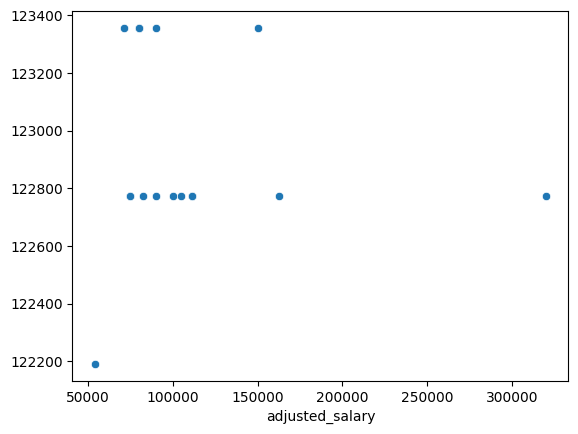

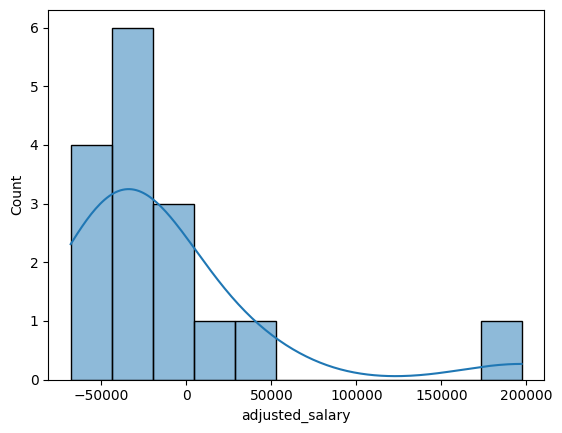

communication R2 Score: -0.04673413113136715


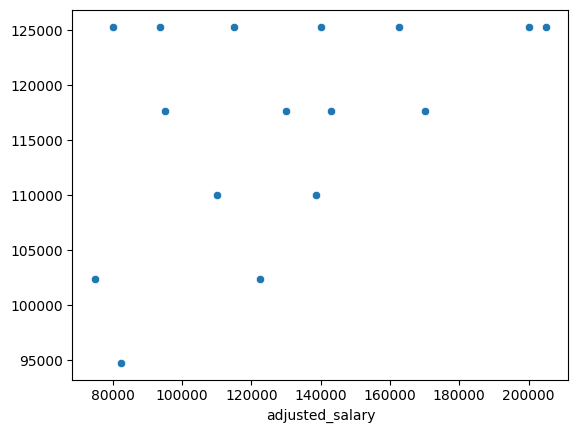

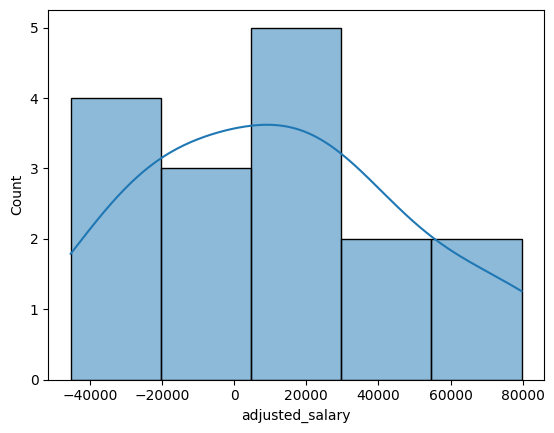

customer_service R2 Score: 0.06755637452616303


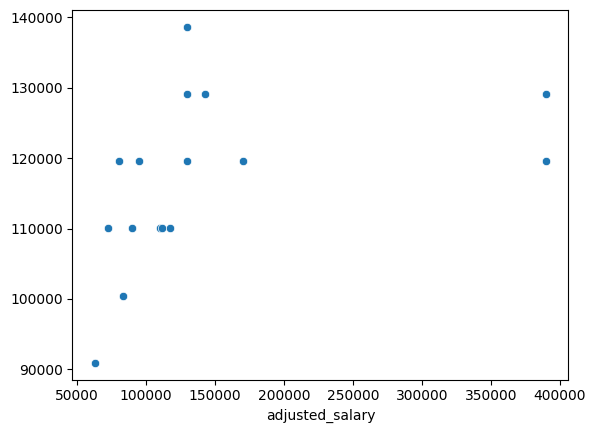

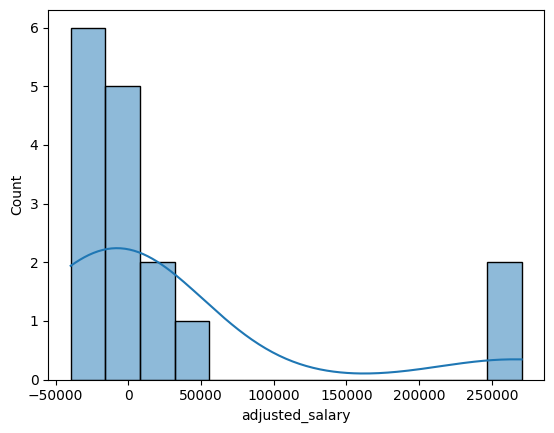

leadership R2 Score: 0.0054801447608365805


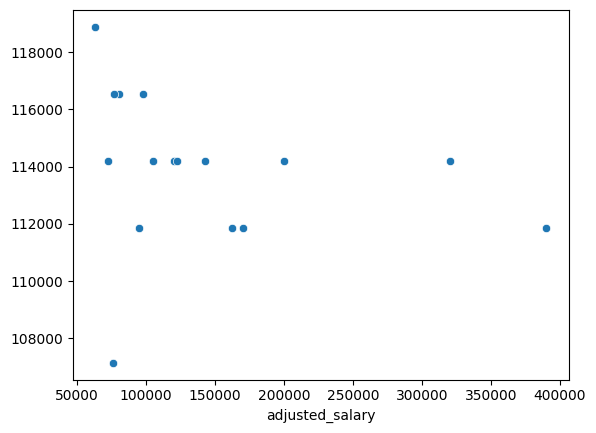

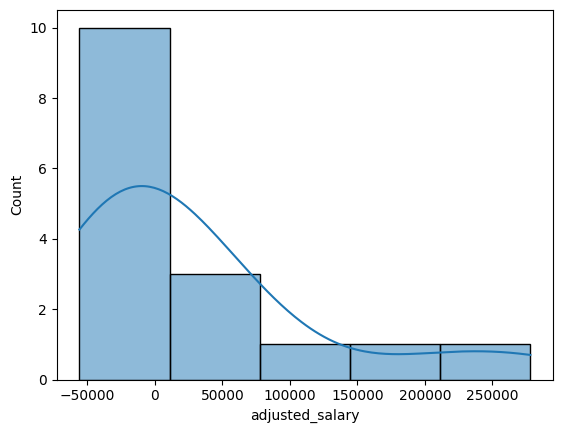

project_management R2 Score: -0.12381920184863016


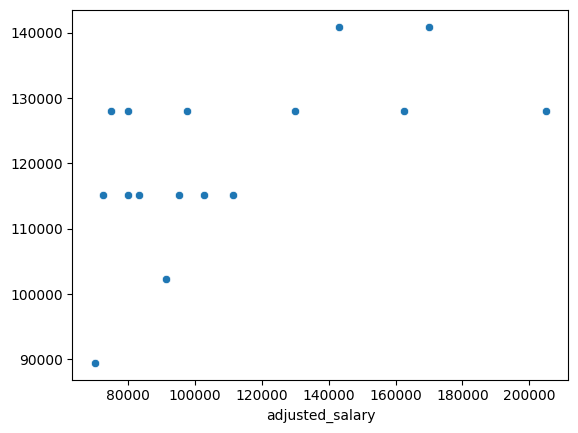

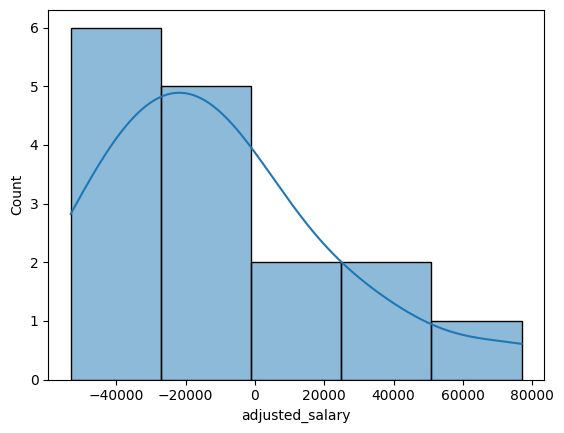

management R2 Score: 0.21349000928497508


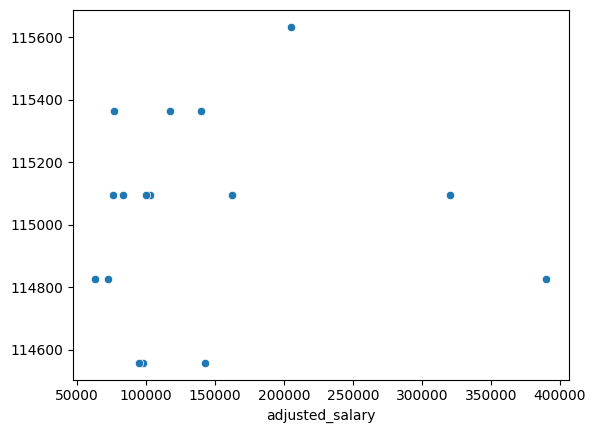

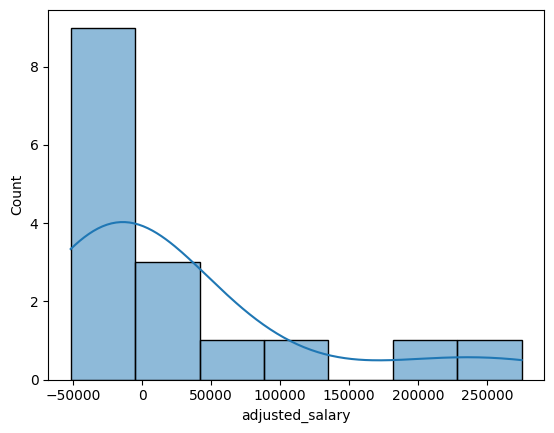

analytics R2 Score: -0.0786835647833879


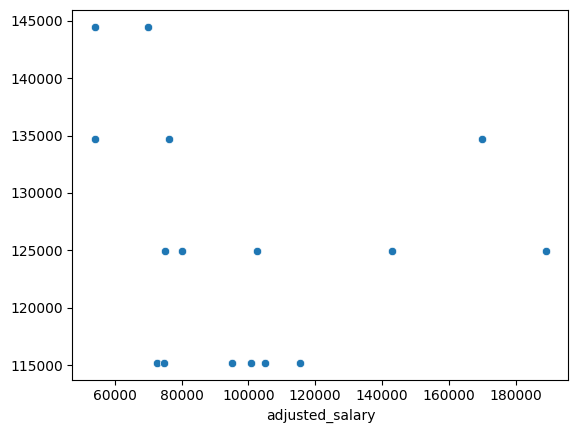

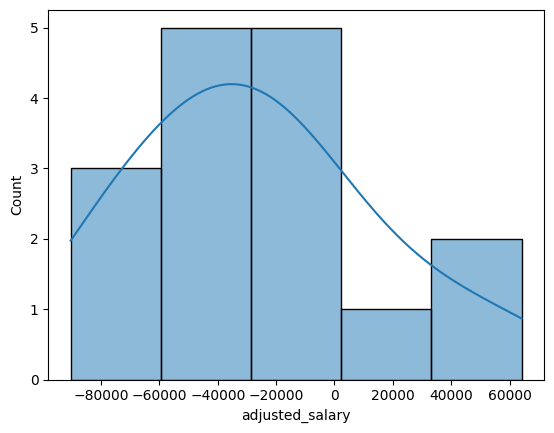

teamwork R2 Score: -0.6716105570920812


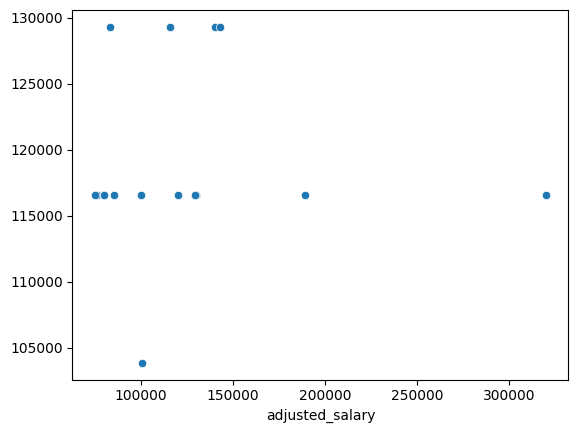

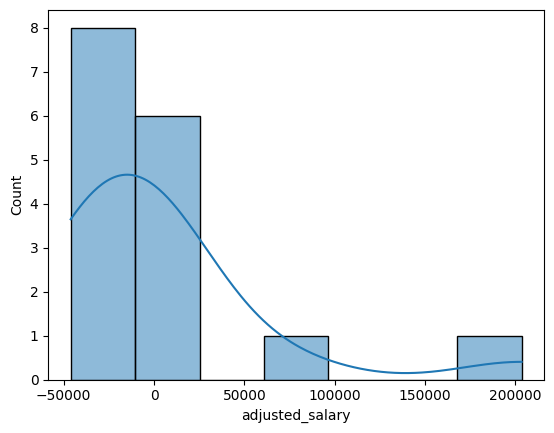

problem_solving R2 Score: -0.011742869521324417


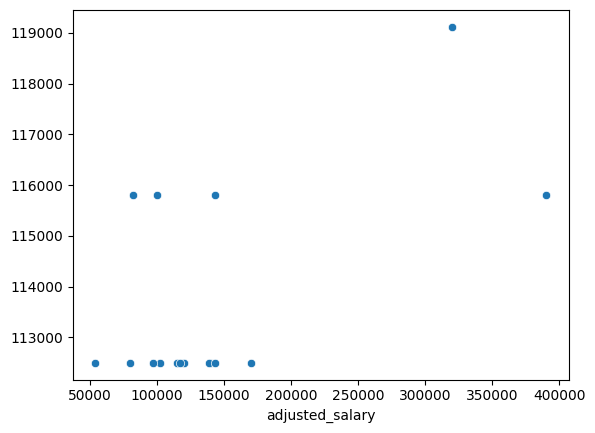

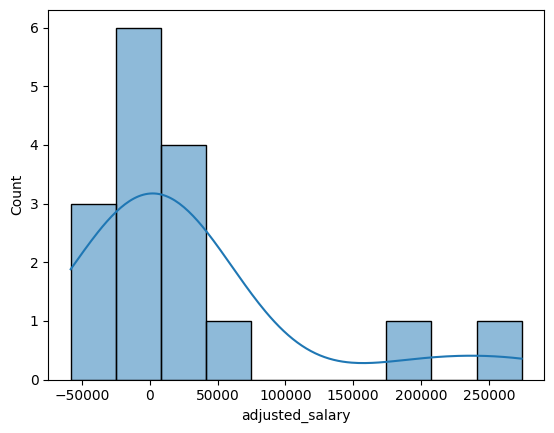

time_management R2 Score: -0.1033965305653306


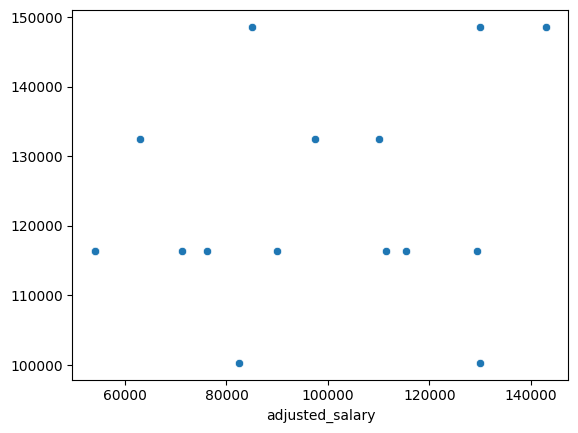

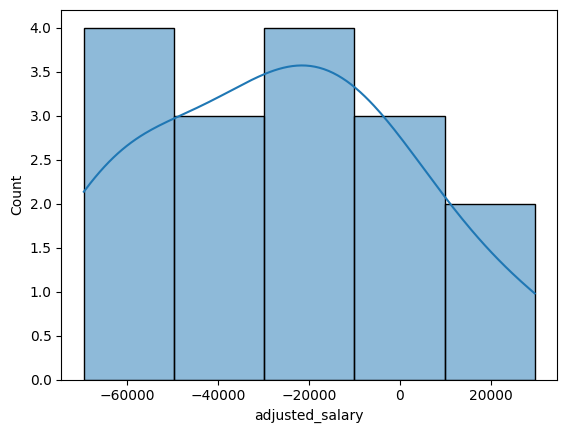

research R2 Score: -0.9793839082972449


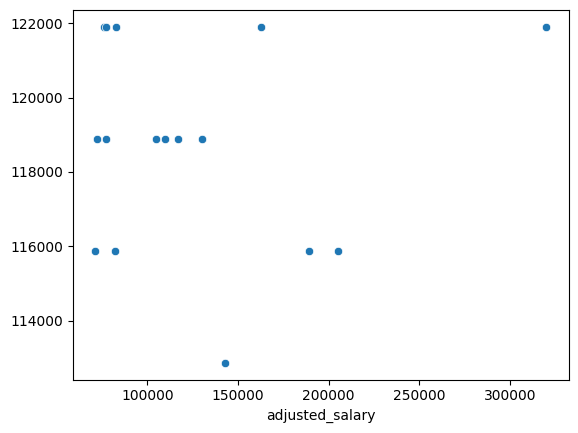

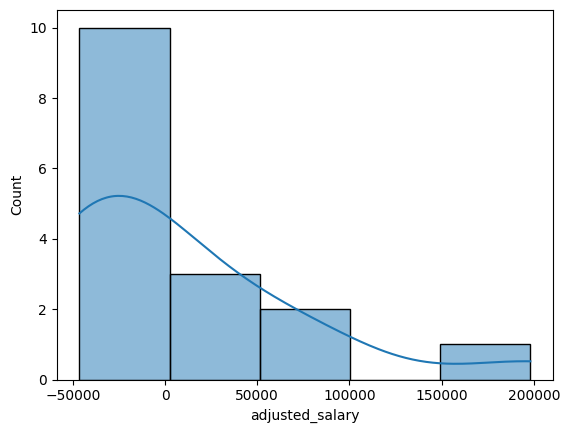

adaptability R2 Score: -0.014421224023276391


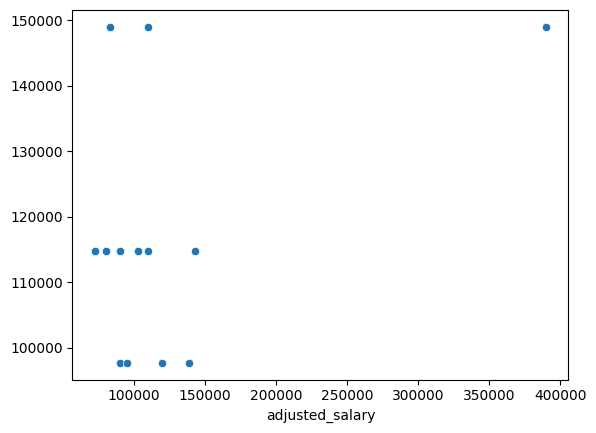

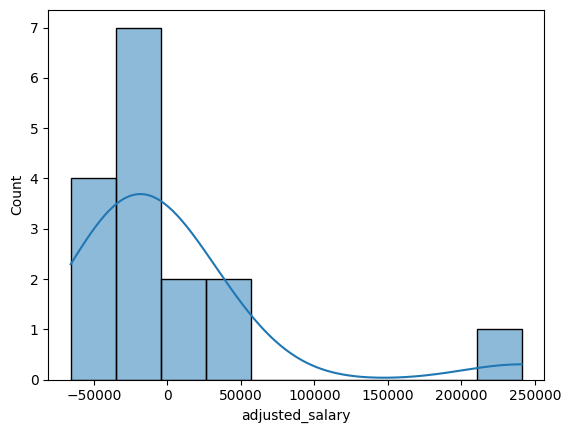

independence R2 Score: 0.1404671954904122


In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

for i in soft_skills:
    train_X, test_X, train_y, test_y = train_test_split(jobs_fixed[[i]], jobs_fixed['adjusted_salary'], test_size = 0.2)

    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
    predictions = linear_model.predict(test_X)
    residuals = test_y - predictions

    sns.scatterplot(x=test_y, y=predictions)   
    plt.show()
    sns.histplot(residuals, kde = True)
    plt.show()
    print('{} R2 Score:'.format(i), r2_score(test_y, predictions))

### Observations
Now, let me be the first to say, we've got some absolutely horrendous readings in here, but it isn't all terrible. There are two soft skills that actually have *some* bearing on adjusted_salary: management and independence. So that's it right? Our hypothesis pertaining to range is correct? High fives all around, call it a day? Not quite.

See if it was range alone that indicated a given soft skill's correlation with salary, we'd see leadership up here we management and independence as well, yet we don't. What does this tell us? Well, first off we have the address some ambiguity. I personally differentiate "leadership" and "management" in that a leader isn't necessarily in charge or people while a manager is. However, there is no real way of knowing exactly how our AI compatriot defines these two ideas. As a result, we can't conclusively say why leadership was far less impactful than management when it comes to predicting adjusted_salary.

What I'm willing to conclude instead is that soft skills are more important for individuals of higher positions than those in entry level. Candidates are expected to reach a bare minimum standard when first coming on, but only a few of those that are brought on reach the level of management. Skills like problem solving and communication are essential for everyone on a team, but management is a skill that can help people ascend into those more exclusive positions. This idea is backed by the data in our table:

In [119]:
jobs_fixed[['name', 'type', 'management', 'adjusted_salary']].sort_values(by = ['management'], ascending = False)

,name,type,management,adjusted_salary
9,Chief Information Security Officer (CISO),2,9,100000.0
54,Information Security Officer,2,9,130000.0
15,Cybersecurity Analyst,1,7,110000.0
10,"Cybersecurity, Privacy and Forensics - Cyber I...",1,7,143000.0
8,AWS Cloud Security Engineer (C2C or Sponsorshi...,1,7,140000.0
...,...,...,...,...
30,Incident Response Analyst I,1,4,54111.2
43,Cybersecurity Analyst Intern,0,3,62962.5
47,Cybersecurity Analyst Intern,0,3,62962.5
89,"Information Security Analyst - Aurora, IL",1,3,70000.0


Of our existing data, we have two, and only two, instances of a 9 for management, both of which are associate level roles (Mid-Senior and higher roles are grossly underrepresented in the dataset as they are far less commonly posted on job boards; however, I anticipate we'd see similar behavior in those positions too). Additionally, looking to adjusted_salary, we can see much higher salaries for those with 7s and 9s for management as opposed to those at 3s and 4s.

Based on this evidence, I'm comfortable making a light conclusion that soft skills are less important for entry level candidates as they are for those in higher managerial roles.